In [1]:
import allantools

In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import math
import csv

In [3]:
def getRandomWalkSegment(tau,sigma):

    m = -0.5 # slope of random walk  随机游走的斜率
    """""""""""""""""""""""""""""""""
    " Find point where slope = -0.5 "
    """""""""""""""""""""""""""""""""
    randomWalk = None
    i = 1
    idx = 1
    mindiff = 999
    logTau = -999
    while (logTau<0):
        logTau = math.log(tau[i],10)
        logSigma = math.log(sigma[i],10)
        prevLogTau = math.log(tau[i-1],10)
        prevLogSigma = math.log(sigma[i-1],10)
        slope = (logSigma-prevLogSigma)/(logTau-prevLogTau)
        diff = abs(slope-m)
        if (diff<mindiff):
            mindiff = diff
            idx = i
        i = i + 1

    """"""""""""""""""""""""""""""
    " Project line to tau = 10^0 "
    """"""""""""""""""""""""""""""
    x1 = math.log(tau[idx],10)
    y1 = math.log(sigma[idx],10)
    x2 = 0
    y2 = m*(x2-x1)+y1

    return (pow(10,x1),pow(10,y1),pow(10,x2),pow(10,y2))

def getBiasInstabilityPoint(tau,sigma):
    i = 1
    while (i<tau.size):
        if (tau[i]>1) and ((sigma[i]-sigma[i-1])>0): # only check for tau > 10^0
            break
        i = i + 1
    return (tau[i],sigma[i])

In [4]:
lags = 1000
numTau = lags
taus = [None]*numTau
cnt = 0;
for i in np.linspace(-2.0, 5.0, num=numTau): 
    # lags will span from 10^-2 to 10^5, log spaced
    taus[cnt] = pow(10,i)
    cnt = cnt + 1

In [6]:
##数据读取
acc = "acc9.txt"
gyro = "gyro9.txt"
with open(acc,'r') as f:
    acc_data = f.readlines()
    acc_data = [i.split('\n')[0] for i in acc_data]
    acc_data = [i.split('   ') for i in acc_data]
with open(gyro,'r') as f:
    gyro_data = f.readlines()
    gyro_data = [i.split('\n')[0] for i in gyro_data]
    gyro_data = [i.split('   ') for i in gyro_data]

acc_data = np.array(acc_data)
acc_data = acc_data[:,1:]
gyro_data = np.array(gyro_data)
gyro_data = gyro_data[:,1:]

In [16]:
a=acc_data.shape
data = np.zeros( (6,a[0]) )

In [17]:
data[0,:] = acc_data.T[0,:]
data[1,:] = acc_data.T[1,:]
data[2,:] = acc_data.T[2,:]
data[3,:] = gyro_data.T[0,:]
data[4,:] = gyro_data.T[1,:]
data[5,:] = gyro_data.T[2,:]

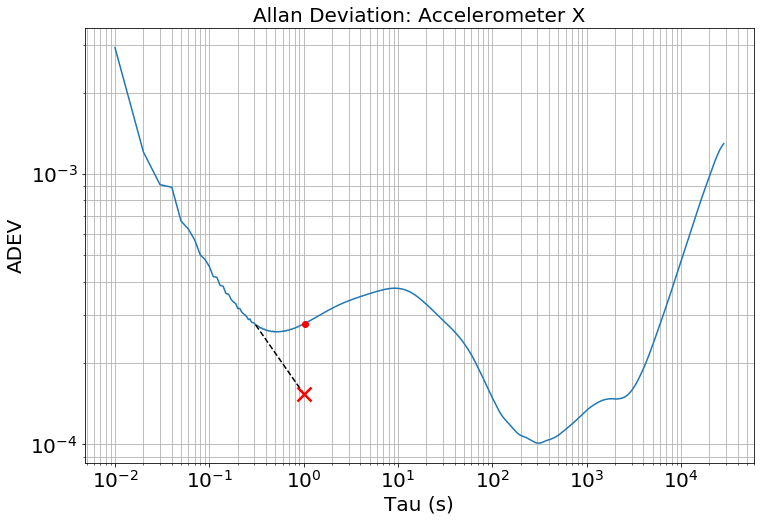

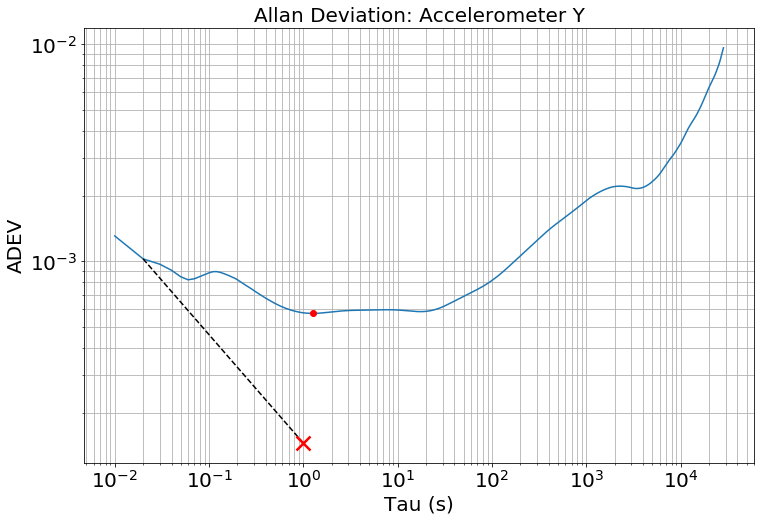

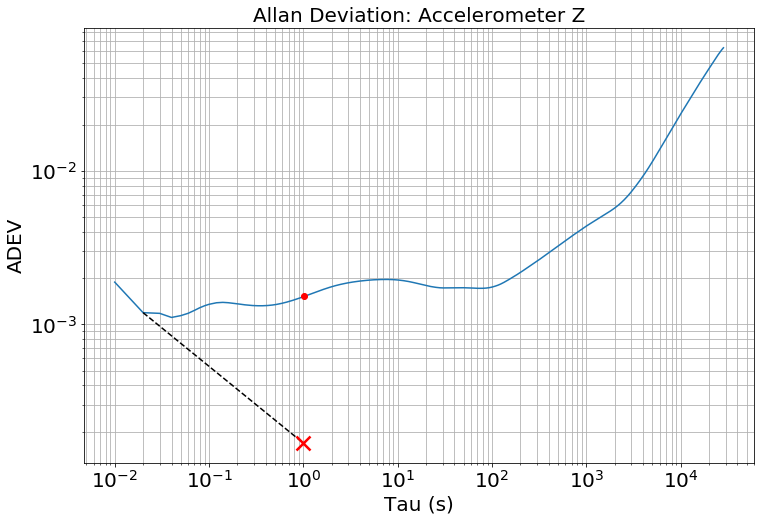

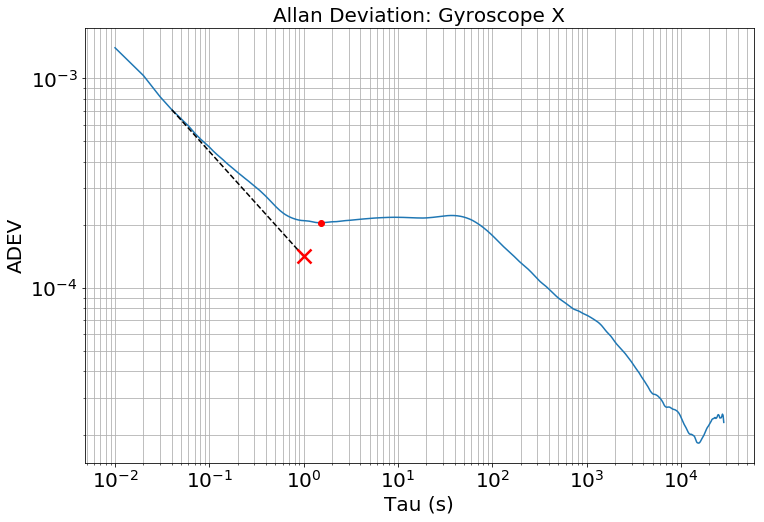

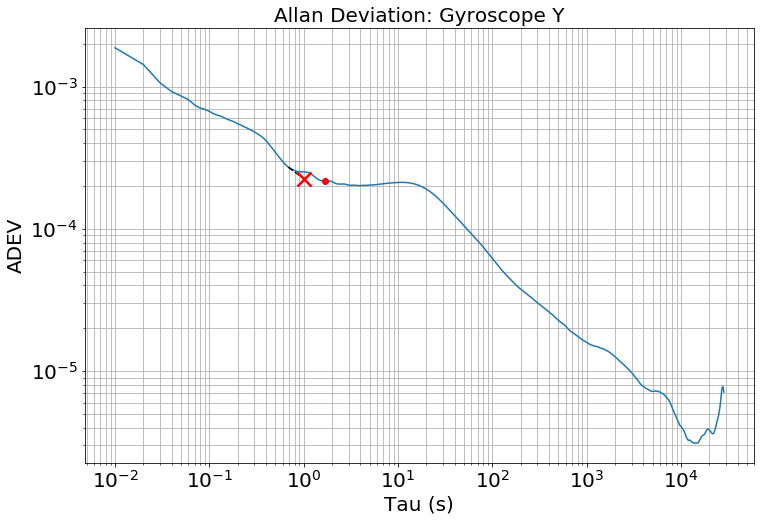

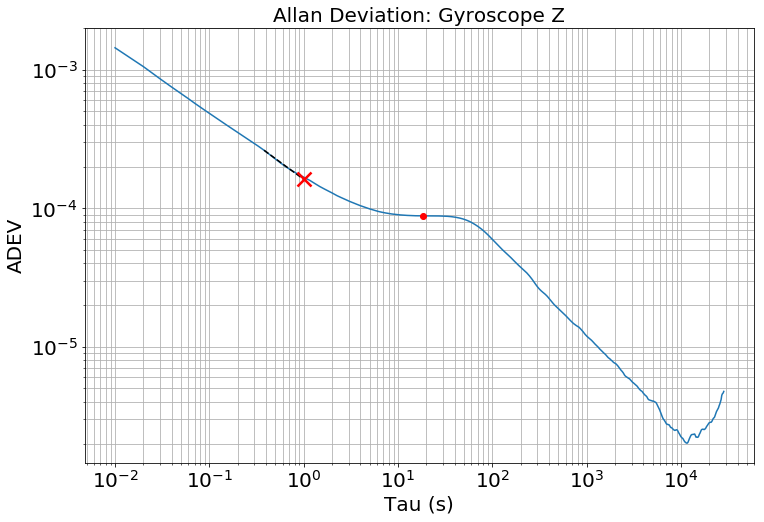

In [24]:
resultsPath = "./"
axis =0 
if axis is 0:
    currentAxis = 1 # loop through all axes 1-6
else:
    currentAxis = axis # just loop one time and break

while (currentAxis <= 6):
    (taus_used, adev, adev_err, adev_n) = allantools.oadev(data[currentAxis-1], data_type='freq', 
                                                           rate=float(100), taus=np.array(taus) )

    randomWalkSegment = getRandomWalkSegment(taus_used,adev)
    biasInstabilityPoint = getBiasInstabilityPoint(taus_used,adev)

    randomWalk = randomWalkSegment[3]
    biasInstability = biasInstabilityPoint[1]
        

    if (currentAxis==1):
        fname = 'allan_accel_x'
        title = 'Allan Deviation: Accelerometer X'
    elif (currentAxis==2):
        fname = 'allan_accel_y'
        title = 'Allan Deviation: Accelerometer Y'
    elif (currentAxis==3):
        fname = 'allan_accel_z'
        title = 'Allan Deviation: Accelerometer Z'
    elif (currentAxis==4):
        fname = 'allan_gyro_x'
        title = 'Allan Deviation: Gyroscope X'
    elif (currentAxis==5):
        fname = 'allan_gyro_y'
        title = 'Allan Deviation: Gyroscope Y'
    elif (currentAxis==6):
        fname = 'allan_gyro_z'
        title = 'Allan Deviation: Gyroscope Z'

    f = open(resultsPath + fname + '.csv', 'wt')

    try:
        writer = csv.writer(f)
        writer.writerow( ('Random_Walk', 'Bias_Instability') )
        writer.writerow( (randomWalk, biasInstability) )
        writer.writerow( ('Tau', 'AllanDev', 'AllanDevError', 'AllanDevN') )
        for i in range(taus_used.size):
            writer.writerow( (taus_used[i],adev[i],adev_err[i],adev_n[i])  )
    finally:
        f.close()

    plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')

    plt.plot(taus_used,adev)
    plt.plot([randomWalkSegment[0],randomWalkSegment[2]],
            [randomWalkSegment[1],randomWalkSegment[3]],'k--')
    plt.plot(1,randomWalk,'rx',markeredgewidth=2.5,markersize=14.0)
    plt.plot(biasInstabilityPoint[0],biasInstabilityPoint[1],'ro')

    plt.grid(True, which="both")
    plt.title(title)
    plt.xlabel('Tau (s)')
    plt.ylabel('ADEV')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

    plt.show(block=False)

    plt.savefig(resultsPath + fname)

    currentAxis = currentAxis + 1 + axis*6 # increment currentAxis also break if axis is not =0


[-0.00066395 -0.00420056 -0.00275365 ...,  0.00216682 -0.00035189
  0.00062784]
